### import librairies

In [67]:
# import librairies and functions needed for project

# utilities
import os
os.environ["OMP_NUM_THREADS"] = '1' # needed to avoid memory leak warning with K-Means in Windows environment
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings

# data
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None) # maximise dataframe display

# modelisation
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import rand_score
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score, fowlkes_mallows_score

# visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})

In [68]:
# Import data & split file
data = pd.read_csv("df_final.csv", encoding='latin_1')

### train_test_split de notre jeu de données df_final (1500, 7)

In [69]:
data['is_genuine'] = data['is_genuine'].map({0: False, 1: True})

In [70]:
# include all variables
x = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']].values
y = data['is_genuine']

# labels
dimensions = data.columns.drop('is_genuine')

# create train & test data sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True, stratify=None)

print(f"Nous avons x_train de forme {x_train.shape} et y_train de forme {y_train.shape}")
unique_yt, counts_yt = np.unique(y_train, return_counts=True)
print("True/False mix in training set:\n", np.asarray((unique_yt, counts_yt)).T)
print(f"Nous avons x_test de forme {x_test.shape} et y_test de forme {y_test.shape}")
unique_ytt, counts_ytt = np.unique(y_test, return_counts=True)
print("True/False mix in testing set:\n", np.asarray((unique_ytt, counts_ytt)).T)

Nous avons x_train de forme (1200, 6) et y_train de forme (1200,)
True/False mix in training set:
 [[  0 390]
 [  1 810]]
Nous avons x_test de forme (300, 6) et y_test de forme (300,)
True/False mix in testing set:
 [[  0 110]
 [  1 190]]


### Standardisation du jeu d'entrainement

In [71]:
# export training & testing sets to re-use for training logistic regression model
pd.DataFrame(x_train, columns=dimensions).to_csv('x_training_set.csv', index=None, encoding='latin_1')
y_train.to_csv('y_training_set.csv', index=False, encoding='latin_1')
pd.DataFrame(x_test, columns=dimensions).to_csv('x_testing_set.csv', index=None, encoding='latin_1')
y_test.to_csv('y_testing_set.csv', index=False, encoding='latin_1')

# center & reduce data
std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(x_train)

### Création d'un dataframe "clusters" des données normalisées

In [72]:
clusters = pd.DataFrame(y_train)
clusters[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
          'length']] = x_train_scaled
clusters['is_genuine'].value_counts()

is_genuine
True     810
False    390
Name: count, dtype: int64

## Entrainement de l'algorithme K-means à 2 clusters

In [73]:
# run K-means
kmeans_2 = KMeans(n_clusters=2, random_state=808, n_init="auto")
kmeans_2.fit(x_train_scaled)
labels_2 = kmeans_2.labels_

# add cluster number to each line in "clusters dataframe"
clusters['cluster_km_2'] = (kmeans_2.labels_)

In [74]:
inertie_2 = round(kmeans_2.inertia_, 2)
print(f"Inertie: {inertie_2} - Nb iterations: {kmeans_2.n_iter_} ")

Inertie: 4655.52 - Nb iterations: 5 


In [75]:
clusters.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_km_2
382,True,1.050853,1.958416,-0.367712,-0.597273,-0.306118,0.648529,0
538,True,-0.185700,1.559864,-1.317963,-0.597273,-1.428167,0.921625,0
1493,False,-1.064303,0.995247,2.115204,0.618912,0.859087,-0.603164,1
1112,False,0.334954,0.829184,1.195606,1.728680,0.513841,-1.229011,1
324,True,0.465117,1.294162,-0.980777,-0.445250,-1.126077,0.716803,0


### Analyse des centroïdes

In [76]:
# create centroids dataframe
centroids_2 = kmeans_2.cluster_centers_
centroids_km_2 = pd.DataFrame(centroids_2)
centroids_km_2.columns = dimensions
centroids_km_2

,diagonal,height_left,height_right,margin_low,margin_up,length
0,0.089125,-0.262568,-0.341261,-0.537078,-0.415777,0.582539
1,-0.190118,0.560100,0.727963,1.145673,0.886919,-1.242648


In [77]:
# plot polar chart centroids
categories = centroids_km_2.columns
fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=centroids_km_2.iloc[0], theta=categories, fill='toself', name='Cluster 1 centroide'))
fig.add_trace(go.Scatterpolar(r=centroids_km_2.iloc[1], theta=categories, fill='toself', name='Cluster 2 centroide'))
fig.update_traces(opacity=0.5, selector=dict(type='scatterpolar'))
fig.show()

In [78]:
# Remplacer les valeurs de la colonne "cluster_km_2" par leur inverse
clusters['cluster_km_2'] = clusters['cluster_km_2'].map({0:'vrai_billet', 1:'faux_billet'})

In [79]:
clusters.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_km_2
382,True,1.050853,1.958416,-0.367712,-0.597273,-0.306118,0.648529,vrai_billet
538,True,-0.185700,1.559864,-1.317963,-0.597273,-1.428167,0.921625,vrai_billet
1493,False,-1.064303,0.995247,2.115204,0.618912,0.859087,-0.603164,faux_billet
1112,False,0.334954,0.829184,1.195606,1.728680,0.513841,-1.229011,faux_billet
324,True,0.465117,1.294162,-0.980777,-0.445250,-1.126077,0.716803,vrai_billet


### Matrice de confusion - KMeans 2 clusters - train set

In [53]:
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion avec les nouvelles étiquettes prédites
confusion_matrix_result = confusion_matrix(clusters['is_genuine'], clusters['cluster_km_2'])

# Afficher la matrice de confusion
print("Matrice de confusion :")
print(confusion_matrix_result)


Matrice de confusion :
[[377  13]
 [  6 804]]


In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

def matrice_confusion(a, b, nom_graphique):
    confusion_matrix = metrics.confusion_matrix(a, b)
    group_names = ['Vrais négatifs','Faux positifs', 'Faux négatifs', 'Vrais positifs']
    group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in confusion_matrix.flatten() / np.sum(confusion_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
    plt.title(nom_graphique)
    plt.show()
    
    classification = metrics.classification_report(a, b)
    print(classification)

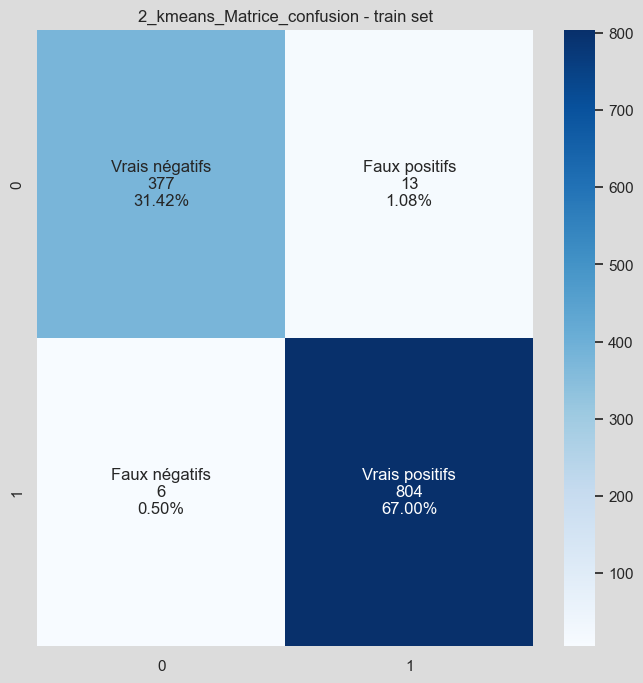

              precision    recall  f1-score   support

       False       0.98      0.97      0.98       390
        True       0.98      0.99      0.99       810

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



In [17]:
matrice_confusion(clusters['is_genuine'], clusters['cluster_km_2'], "2_kmeans_Matrice_confusion - train set")

- Sur 810 vrais billets, 6 sont predits faux (0.7% de faux negatifs). 

- Sur 390 faux billets, 13 sont predits vrais (3.33% de faux positifs).

### Performances du modèle à 2 Clusters sur train set

In [18]:
# calculate Rand score = (number of agreeing pairs) / (number of pairs)
print("Rand score:", rand_score(clusters['is_genuine'], clusters['cluster_km_2']))

# calculate adjusted Rand score. Perfect labeling would be scored 1 and bad labelling or independent labelling is scored
# 0 or negative.
print("Adjusted rand score:", adjusted_rand_score(clusters['is_genuine'], clusters['cluster_km_2']))

from sklearn.metrics import accuracy_score

print("accuracy_score",accuracy_score(clusters['is_genuine'], clusters['cluster_km_2']))

print("MIB:", normalized_mutual_info_score (clusters['is_genuine'], clusters['cluster_km_2']))

print("Adjusted MIB:", adjusted_mutual_info_score(clusters['is_genuine'], clusters['cluster_km_2']))
print("FM score:", fowlkes_mallows_score(clusters['is_genuine'], clusters['cluster_km_2']))

Rand score: 0.9688087294968029
Adjusted rand score: 0.9366134581986845
accuracy_score 0.9841666666666666
MIB: 0.8740066833488348
Adjusted MIB: 0.8739229387961293
FM score: 0.9723037747907189


### Fowlkes-Mallows Score

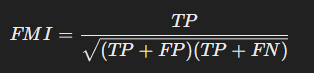

Le score Fowlkes-Mallows (FMI) est une mesure de similarité entre deux ensembles d'étiquettes, souvent utilisée pour évaluer la qualité des algorithmes de clustering. 

- Il est défini comme la racine carrée de la proportion du nombre de paires d'éléments qui sont dans la même classe à la fois dans les ensembles d'étiquettes et dans les clusters prédits, divisée par la racine carrée du produit du nombre total de paires d'éléments dans les deux ensembles.

Où :

TP (True Positives) : Le nombre de paires d'éléments qui sont dans la même classe à la fois dans les ensembles d'étiquettes et dans les clusters prédits.
FP (False Positives) : Le nombre de paires d'éléments qui sont dans la même classe dans les clusters prédits mais dans des classes différentes dans les ensembles d'étiquettes.
FN (False Negatives) : Le nombre de paires d'éléments qui sont dans la même classe dans les ensembles d'étiquettes mais dans des clusters différents dans les clusters prédits.

- Le score FMI varie entre 0 et 1, où 1 indique une parfaite correspondance entre les ensembles d'étiquettes et les clusters prédits, et 0 indique une absence de correspondance.

En résumé, le score Fowlkes-Mallows mesure à quel point les clusters prédits correspondent aux vrais groupements des données, en tenant compte à la fois des vrais positifs, des faux positifs et des faux négatifs.

In [19]:
print("FM score:", fowlkes_mallows_score(clusters['is_genuine'], clusters['cluster_km_2']))

FM score: 0.9723037747907189


Un score Fowlkes-Mallows (FMI) de 0.9723 est un excellent résultat, indiquant une très bonne similarité entre les ensembles d'étiquettes (les vrais groupements des données) et les clusters prédits par notre algorithme de clustering.

### Evaluation de la performance du K-means à 2 Clusters sur le "testing set"

In [60]:
# scale data
x_test_scaled = std_scaler.transform(x_test)

# create dataframe to store results
clusters_test = pd.DataFrame(y_test)
clusters_test[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
               'length']] = x_test_scaled

# run K-means
kmeans_2.fit_predict(x_test_scaled)
labels_final_test = kmeans_2.labels_

# add cluster number to each occurence in clusters_test dataframe
clusters_test['cluster_pred_test'] = labels_final_test

# Remplacer les valeurs de la colonne "cluster_km_2" par leur inverse
clusters_test['cluster_pred_test'] = clusters_test['cluster_pred_test'].map({0: True, 1: False})
clusters_test.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_pred_test
1116,False,0.985771,-0.432900,0.613193,0.786137,1.161177,-1.615898,False
1368,False,-0.999222,0.962034,1.410179,1.789489,0.384374,-0.443858,False
422,True,-1.389712,-1.661771,-0.888817,-0.658082,-0.823987,0.079577,True
413,True,1.115935,-1.230006,-1.287310,-0.487741,0.039128,0.295779,True
451,True,0.692904,-0.798240,-1.164697,-0.612475,-1.600790,0.386811,True


### Matrice de confusion - 2 Clusters - test set

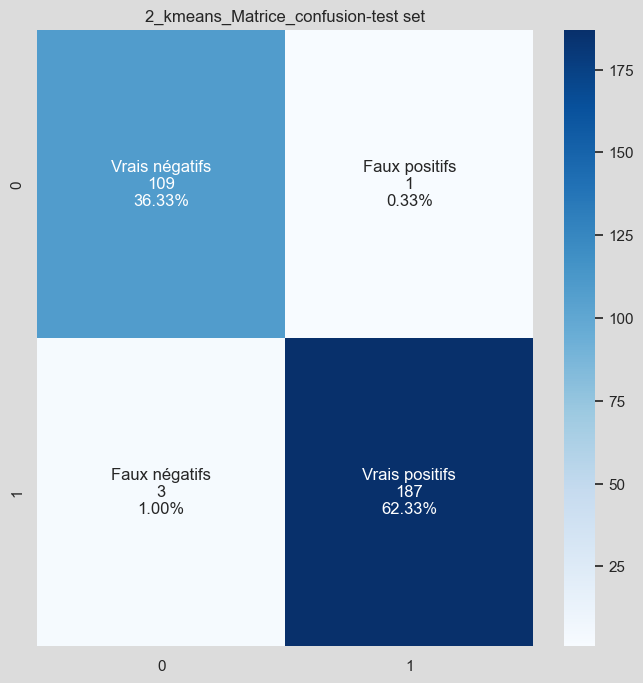

              precision    recall  f1-score   support

       False       0.97      0.99      0.98       110
        True       0.99      0.98      0.99       190

    accuracy                           0.99       300
   macro avg       0.98      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [61]:
matrice_confusion(clusters_test['is_genuine'], clusters_test['cluster_pred_test'], "2_kmeans_Matrice_confusion-test set")

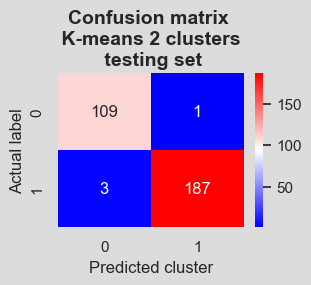

In [62]:
# heatmap of confusion matrix
conf_kmtest = confusion_matrix(clusters_test['is_genuine'], clusters_test['cluster_pred_test'])
fig, ax = plt.subplots(figsize=(3, 2))
conf_kmtest = pd.DataFrame(conf_kmtest)
sns.heatmap(conf_kmtest, annot=True, cmap="bwr", fmt='g')
plt.title('Confusion matrix \n K-means 2 clusters \n testing set', fontsize=14, fontweight='bold')
plt.ylabel('Actual label', fontsize=12)
plt.xlabel('Predicted cluster', fontsize=12)
plt.savefig("conf_matrix_kmtest.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

***********************************************************************

### Performances du modèle 2 Clusters sur le jeu test

In [23]:
# calculate Rand score = (number of agreeing pairs) / (number of pairs)
print("Rand score:", rand_score(clusters_test['is_genuine'], clusters_test['cluster_pred_test']))
print("accuracy_score",accuracy_score(clusters_test['is_genuine'], clusters_test['cluster_pred_test']))
# calculate adjusted Rand score. Perfect labeling would be scored 1 and bad labelling or independent labelling is scored
# 0 or negative.
print("Adjusted rand score:", adjusted_rand_score(clusters_test['is_genuine'], clusters_test['cluster_pred_test']))

print("MIB:", normalized_mutual_info_score (clusters_test['is_genuine'], clusters_test['cluster_pred_test']))

print("Adjusted MIB:", adjusted_mutual_info_score(clusters_test['is_genuine'], clusters_test['cluster_pred_test']))

print("FM score:", fowlkes_mallows_score(clusters_test['is_genuine'], clusters_test['cluster_pred_test']))

Rand score: 0.9736008918617615
accuracy_score 0.9866666666666667
Adjusted rand score: 0.9469816764574738
MIB: 0.8958662114412843
Adjusted MIB: 0.8956005456730549
FM score: 0.9752062780873688


### Prediction sur l'echantillon de production avec l'algorithme de classification KMeans 2 Clusters

In [24]:
# Import data
data_prod = pd.read_csv("billets_production.csv", encoding='latin_1')

# check for missing values
if (data_prod.loc[data_prod.isna().any(axis=1) == True].shape[0]) != 0:
    print("!!! Valeurs manquantes !!!")
else:
    print ("Pas de valeurs manquantes.")
# check for missing data
if (data_prod.loc[data_prod.isnull().any(axis=1) == True].shape[0]) != 0:
    print("!!! Valeurs nulles !!! ")
else:
    print ("Pas de valeurs nulles.")
# check for duplicates
if (data_prod.loc[data_prod.duplicated() == True].shape[0]) != 0:
    print("!!! Doublons dans la table !!!")
else:
    print ("Pas de doublons dans la table.")

Pas de valeurs manquantes.
Pas de valeurs nulles.
Pas de doublons dans la table.


In [81]:
# split file
banknote_production = data_prod[['diagonal', 'height_left', 'height_right', 'margin_low',
                      'margin_up', 'length']].values

# scale data
banknote_production = std_scaler.transform(banknote_production)

# run K-means
kmeans_2.fit_predict(banknote_production)
labels_final = kmeans_2.labels_

# add cluster number to each occurence in clusters dataframe
data_prod['cluster_prediction_prod'] = labels_final

data_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,id,cluster_prediction_prod
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1


**************************************************************************************************